# Chebyshev's bounds

Chebyshev's inequality (also called the Bienaymé–Chebyshev inequality) guarantees that, for a wide class of probability distributions, no more than a certain fraction of values can be more than a certain distance from the mean. Specifically, no more than 1/k2 of the distribution's values can be k or more standard deviations away from the mean (or equivalently, over 1 − 1/k2 of the distribution's values are less than k standard deviations away from the mean). The rule is often called Chebyshev's theorem, about the range of standard deviations around the mean, in statistics. 

As shown in the example above, the theorem typically provides rather loose bounds. However, these bounds cannot in general (remaining true for arbitrary distributions) be improved upon. The bounds are sharp for the following example: for any k ≥ 1,

$X=\left\{\begin{array}{ll}
-1, & \text { with probability } \frac{1}{2 k^{2}} \\
0, & \text { with probability } 1-\frac{1}{k^{3}} \\
1, & \text { with probability } \frac{1}{2 k^{2}}
\end{array}\right.$

For this distribution, the mean μ = 0 and the standard deviation $\sigma=\frac{1}{k}$ so.

$\operatorname{Pr}(|X-\mu| \geq k \sigma)=\operatorname{Pr}(|X| \geq 1)=\frac{1}{k^{2}}$

Chebyshev's inequality is an equality for precisely those distributions that are a linear transformation of this example.

## What about Voronoi?

The Voronoi partition is also called a Voronoi tessellation, diagram or decomposition. While one may consider the partition with respect to other norms, the euclidean norm is the standard choice. In this case the so-called Delaunay complex is the dual of the Voronoi diagram [Rakovic et al., 2004]. The Delaunay Complex is commonly called The Delaunay triangulation. It does in fact not satisfy the formal requirements for being a triangulation unless the set of points generating the complex satisfy certain regularity conditions. A cell complex or just complex is a collection of polytopes with some additional mutual structure. See for instance [Fukuda, 2016$]$ for a definition. The collection of Voronoi cells is in fact a cell complex, hence the name Voronoi cell.

In [61]:
from math import pi, sqrt
from cvxopt import matrix, spmatrix, mul, cos, sin, solvers, blas, lapack
solvers.options['show_progress'] = False

try: import pylab
except ImportError: pylab_installed = False
else: pylab_installed = True

def cheb(A, b, Sigma):

    # Calculates Chebyshev lower bound on Prob(A*x <= b) where
    # x in R^2 has mean zero and covariance Sigma.
    #
    # maximize    1 - tr(Sigma*P) - r
    # subject to  [ P,                    q - (tauk/2)*ak ]
    #             [ (q - (tauk/2)*ak)',   r - 1 + tauk*bk ] >= 0,
    #                                                 k = 0,...,m-1
    #             [ P,   q ]
    #             [ q',  r ] >= 0
    #             tauk >= 0, k=0,...,m-1.
    #
    # variables P[0,0], P[1,0], P[1,1], q[0], q[1], r, tau[0], ..., 
    #     tau[m-1].

    m = A.size[0]
    novars = 3 + 2 + 1 + m

    # Cost function.
    c = matrix(0.0, (novars,1))
    c[0], c[1], c[2] = Sigma[0,0], 2*Sigma[1,0], Sigma[1,1]
    c[5] = 1.0

    Gs = [ spmatrix([],[],[], (9,novars)) for k in range(m+1) ]

    # Coefficients of P, q, r in LMI constraints.
    for k in range(m+1):
        Gs[k][0,0] = -1.0   # P[0,0]
        Gs[k][1,1] = -1.0   # P[1,0]
        Gs[k][4,2] = -1.0   # P[1,1]
        Gs[k][2,3] = -1.0   # q[0]
        Gs[k][5,4] = -1.0   # q[1]
        Gs[k][8,5] = -1.0   # r
    # Coefficients of tau.
    for k in range(m):
        Gs[k][2, 6+k] = 0.5 * A[k,0]   
        Gs[k][5, 6+k] = 0.5 * A[k,1]   
        Gs[k][8, 6+k] = -b[k]   
    
    hs = [ matrix(8*[0.0] + [-1.0], (3,3)) for k in range(m) ] + \
        [ matrix(0.0, (3,3)) ]

    # Constraints tau >= 0.
    Gl, hl = spmatrix(-1.0, range(m), range(6,6+m)), matrix(0.0, (m,1)) 

    sol = solvers.sdp(c, Gl, hl, Gs, hs)
    P = matrix(sol['x'][[0,1,1,2]], (2,2))  
    q = matrix(sol['x'][[3,4]], (2,1))  
    r = sol['x'][5]
    bound = 1.0 - Sigma[0]*P[0] - 2*Sigma[1]*P[1] - Sigma[3]*P[3] - r

    # Worst-case distribution from dual solution.
    X = [ Z[2,:2].T / Z[2,2] for Z in sol['zs'] if Z[2,2] > 1e-5 ]

    return bound, P, q, r, X

In [62]:
# Extreme points and inequality description of Voronoi region around 
# first symbol (0,0).
m = 6
V = matrix([ 1.0,  1.0, 
            -1.0,  2.0,
            -2.0,  1.0,
            -2.0, -1.0,
             0.0, -2.0,
             1.5, -1.0,
             1.0,  1.0 ], (2,m+1))

A0 = matrix([-(V[1,:m] - V[1,1:]), V[0,:m] - V[0,1:]]).T
b0 = mul(A0, V[:,:m].T) * matrix(1.0, (2,1))

# List of symbols.
C = [ matrix(0.0, (2,1)) ] + \
    [ 2.0 * b0[k] / blas.nrm2(A0[k,:])**2 * A0[k,:].T for k in range(m) ]

# Voronoi set around C[1]
A1, b1 = matrix(0.0, (3,2)), matrix(0.0, (3,1))
A1[0,:] = -A0[0,:]
b1[0] = -b0[0]
A1[1,:] = (C[m] - C[1]).T
b1[1] = 0.5 * A1[1,:] * ( C[m] + C[1] )
A1[2,:] = (C[2] - C[1]).T
b1[2] = 0.5 * A1[2,:] * ( C[2] + C[1] )

# Voronoi set around C[2]
A2, b2 = matrix(0.0, (3,2)), matrix(0.0, (3,1))
A2[0,:] = -A0[1,:]
b2[0] = -b0[1]
A2[1,:] = (C[1] - C[2]).T
b2[1] = 0.5 * A2[1,:] * ( C[1] + C[2] )
A2[2,:] = (C[3] - C[2]).T
b2[2] = 0.5 * A2[2,:] * ( C[3] + C[2] )



Computing lower bounds for symbol 0 ...


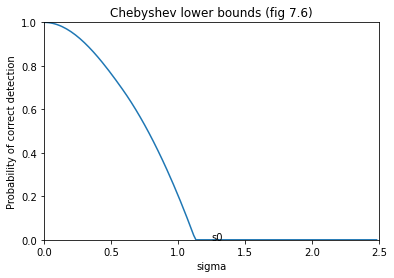

In [63]:
# Compute bounds for s0 with sigma in [0,2.5]
nosigmas = 150
sigmas = 0.001 + (2.5 - 0.001) / nosigmas * matrix(list(range(nosigmas)), 
    tc='d')
I = matrix([1.0, 0.0, 0.0, 1.0], (2,2))
print("Computing lower bounds for symbol 0 ...")
bnds0 = [ cheb(A0, b0, sigma**2*I)[0] for sigma in sigmas ]

if pylab_installed:
    pylab.figure(2,facecolor='w')
    pylab.plot(sigmas, bnds0)
    pylab.axis([0, 2.5, 0.0, 1.0])
    pylab.title('Chebyshev lower bounds (fig 7.6)')
    pylab.text(sigmas[int(nosigmas/2)], bnds0[int(nosigmas/2)], 's0')
    pylab.xlabel('sigma')
    pylab.ylabel('Probability of correct detection')
    #print("Close figure to continue.")
    #pylab.show()

Computing lower bounds for symbol 1 ...


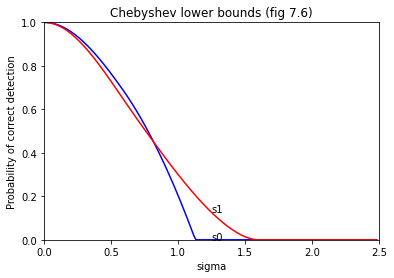

In [64]:
# Bounds for s1.
b1 -= A1*C[1]  # put s1 at the origin
print("Computing lower bounds for symbol 1 ...")
bnds1 = [ cheb(A1, b1, sigma**2*I)[0] for sigma in sigmas ]

if pylab_installed:
    pylab.figure(2,facecolor='w')
    pylab.plot(sigmas,bnds0, '-b', sigmas, bnds1, 'r')
    pylab.axis([0, 2.5, 0.0, 1.0])
    pylab.title('Chebyshev lower bounds (fig 7.6)')
    pylab.text(sigmas[int(nosigmas/2)], bnds0[int(nosigmas/2)], 's0')
    pylab.text(sigmas[int(nosigmas/2)], bnds1[int(nosigmas/2)], 's1')
    pylab.xlabel('sigma')
    pylab.ylabel('Probability of correct detection')
    #print("Close figure to continue.")
    #pylab.show()

Computing lower bounds for symbol 2 ...


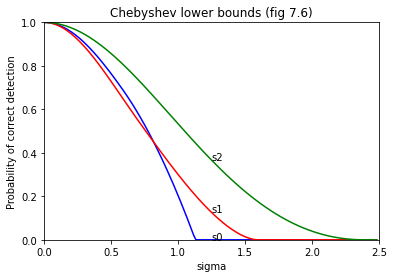

In [65]:
# Bounds for s2.
b2 -= A2*C[2]  # put s2 at the origin
print("Computing lower bounds for symbol 2 ...")
bnds2 = [ cheb(A2, b2, sigma**2*I)[0] for sigma in sigmas ]

if pylab_installed:
    pylab.figure(2,facecolor='w')
    pylab.plot(sigmas,bnds0, '-b', sigmas, bnds1, 'r', sigmas, bnds2, 'g')
    pylab.axis([0, 2.5, 0.0, 1.0])
    pylab.title('Chebyshev lower bounds (fig 7.6)')
    pylab.text(sigmas[int(nosigmas/2)], bnds0[int(nosigmas/2)], 's0')
    pylab.text(sigmas[int(nosigmas/2)], bnds1[int(nosigmas/2)], 's1')
    pylab.text(sigmas[int(nosigmas/2)], bnds2[int(nosigmas/2)], 's2')
    pylab.xlabel('sigma')
    pylab.ylabel('Probability of correct detection')

    #pylab.show()

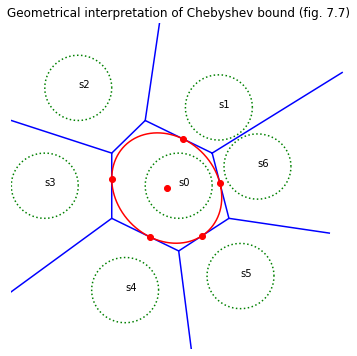

In [66]:
# Compute bound for s0 with sigma = 1.0.
# Write ellipse {x | x'*P*x + 2*q'*x + r = 1} in the form 
# {xc + L^{-T}*u | ||u||_2 = 1}

Sigma = matrix([1.0, 0.0, 0.0, 1.0], (2,2))
bnd, P, q, r, X = cheb(A0, b0, Sigma)
xc = -q
L = +P
lapack.posv(L, xc)
L /= sqrt(1 - r - blas.dot(q, xc))

if pylab_installed:
    def makefig1():
        pylab.figure(1, facecolor='w', figsize=(6,6))
        pylab.plot(V[0,:].T, V[1,:].T, 'b-')
        nopts = 1000
        angles = matrix( [a*2.0*pi/nopts for a in range(nopts) ], 
            (1,nopts) )
        circle = matrix(0.0, (2,nopts))
        circle[0,:], circle[1,:] = cos(angles), sin(angles)
        for k in range(len(C)):
            c = C[k]
            pylab.plot([c[0]], [c[1]], 'ow')
            pylab.text(c[0], c[1], "s%d" %k)
            pylab.plot(c[0] + circle[0,:].T, c[1]+circle[1,:].T, 'g:')
            if k >= 1:
                v = V[:,k-1]
                if k==1: 
                    dir = 0.5 * (C[k] + C[-1]) - v
                else: 
                    dir = 0.5 * (C[k] + C[k-1]) - v
                pylab.plot([v[0], v[0] + 5*dir[0]], 
                    [v[1], v[1] + 5*dir[1]], 'b-')
        ellipse = +circle
        blas.trsm(L, ellipse, transA='T')
        pylab.plot(xc[0] + ellipse[0,:].T, xc[1]+ellipse[1,:].T, 'r-')
        for Xk in X: 
            pylab.plot([Xk[0]], [Xk[1]], 'ro')
    
        pylab.axis([-5, 5, -5, 5])
        pylab.title('Geometrical interpretation of Chebyshev bound (fig. 7.7)')
        pylab.axis('off')
    makefig1()
    #print("Close figure to continue.")
    #pylab.show()

### References:

1. ^ Kvanli, Alan H.; Pavur, Robert J.; Keeling, Kellie B. (2006) Concise Managerial Statistics ISBN $9780324223880 .$
2. ^ Johan Hatleskog (2018) Voronoi Based Deployment for Multi-Agent Systems NTNU Norwegian University of Science and Technology